In [1]:
###################################################
# 0. Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from tqdm.notebook import tqdm
import re
import pickle as pkl
import cv2
import albumentations
import time
import datetime
import os
import gc
import time
import wandb

from PIL import Image
pd.set_option('max_colwidth', None)

import tensorflow as tf
tf.keras.backend.clear_session()

physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Invalid device or cannot modify virtual devices once initialized.')

from tensorflow.keras import models, layers, regularizers, metrics, losses, optimizers, constraints
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

# https://iupac.org/100/stories/what-on-earth-is-inchi/
# tokenizer -> https://www.kaggle.com/yasufuminakama/inchi-preprocess-2
###################################################

In [2]:
# wandb.init(project='Bristol', entity='enric1296')

In [3]:
###################################################
# 1. Paths

PATH_DATA = '../01_Data/'
PATH_MODELS = '../03_Models/'

PATH_DATA_TRAIN = PATH_DATA + 'train/'
PATH_DATA_TEST = PATH_DATA + 'test/'

list_imgs_train_paths = glob.glob(PATH_DATA_TRAIN + '/*/*/*/*')
list_imgs_test_paths = glob.glob(PATH_DATA_TEST + '/*/*/*/*')

print(f'Num Imgs train: {len(list_imgs_train_paths)}')
print(f'Num Imgs test: {len(list_imgs_test_paths)}')

list_imgs_train = [path.split('\\')[-1].split('.')[0] for path in tqdm(list_imgs_train_paths)]
list_imgs_test = [path.split('\\')[-1].split('.')[0] for path in tqdm(list_imgs_test_paths)]

dict_imgs_train_paths = {path.split('\\')[-1].split('.')[0] : path for path in tqdm(list_imgs_train_paths)}
dict_imgs_test_paths = {path.split('\\')[-1].split('.')[0] : path for path in tqdm(list_imgs_test_paths)}


VERSION = '001'
SEQ_LEN_INCHI = 275
SEQ_LEN_REST_INCHI = 255
SEQ_LEN_CHFORM = 20
IMG_SIZE = (220, 340)

###################################################

Num Imgs train: 2424186
Num Imgs test: 1616107


In [4]:
###################################################
# 2. Classes & Functions

def splitFormula(form):
    string = ''
    for i in re.findall(r"[A-Z][^A-Z]*", form):
        elem = re.match(r"\D+", i).group()
        num = i.replace(elem, "")
        if num == "":
            string += f"{elem} "
        else:
            string += f"{elem} {str(num)} "
    return string.rstrip(' ')


def splitFormula2(form):
    string = ''
    for i in re.findall(r"[a-z][^a-z]*", form):
        elem = i[0]
        num = i.replace(elem, "").replace('/', "")
        num_string = ''
        for j in re.findall(r"[0-9]+[^0-9]*", num):
            num_list = list(re.findall(r'\d+', j))
            assert len(num_list) == 1, f"len(num_list) != 1"
            _num = num_list[0]
            if j == _num:
                num_string += f"{_num} "
            else:
                extra = j.replace(_num, "")
                num_string += f"{_num} {' '.join(list(extra))} "
        string += f"/{elem} {num_string}"
    return string.rstrip(' ')


class Tokenizer(object):
    
    def __init__(self):
        self.stoi = {}
        self.itos = {}

    def __len__(self):
        return len(self.stoi)
    
    def fit_on_texts(self, texts):
        vocab = set(['<pad>', '<sos>', '<eos>'])
        for text in texts:
            vocab.update(text.split(' '))
        for i, s in enumerate(vocab):
            self.stoi[s] = i
        self.itos = {item[1]: item[0] for item in self.stoi.items()}
        
    def text_to_sequence(self, text):
        sequence = []
        sequence.append(self.stoi['<sos>'])
        for s in text.split(' '):
            sequence.append(self.stoi[s])
        sequence.append(self.stoi['<eos>'])
        return sequence
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = self.text_to_sequence(text)
            sequences.append(sequence)
        return sequences

    def sequence_to_text(self, sequence):
        return ''.join(list(map(lambda i: self.itos[i], sequence)))
    
    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = self.sequence_to_text(sequence)
            texts.append(text)
        return texts
    
    def predict_caption(self, sequence):
        caption = ''
        for i in sequence:
            if i == self.stoi['<eos>'] or i == self.stoi['<pad>']:
                break
            caption += self.itos[i]
        return caption
    
    def predict_captions(self, sequences):
        captions = []
        for sequence in sequences:
            caption = self.predict_caption(sequence)
            captions.append(caption)
        return captions

###################################################

In [5]:
###################################################
# 3. Load Data

# 2.0 - Load labels

with open(f'{PATH_MODELS}df_train_labels_{VERSION}.pkl', 'rb') as f:
    df_train_labels = pkl.load(f)

# 2.1 - Load tokenizer

with open(f'{PATH_MODELS}tokenizer_experiment_{VERSION}.pkl', 'rb') as f:
    tokenizer = pkl.load(f)
    
EMB_DIM = len(tokenizer.stoi)

###################################################

In [6]:
###################################################
# 4. Preprocess  

df_train_labels['ch_form'] = df_train_labels['l_0'].apply(lambda x: splitFormula(x))
df_train_labels['rest_inchi'] = df_train_labels.apply(lambda x: x['text'][len(x ['ch_form']):].strip(), axis=1)

dict_train_data = {}
list_rows = df_train_labels.to_dict('records')
for row in tqdm(list_rows):
    image_id = row['image_id']
    # ch_form = tokenizer.texts_to_sequences([row['ch_form']])
    #rest_inchi = tokenizer.texts_to_sequences([row['rest_inchi']])
    complete_inchi = tokenizer.texts_to_sequences([row['text']])
    #dict_train_data[image_id] = {'ch_form' : ch_form, 'rest_inchi' : rest_inchi, 'complete_inchi' : complete_inchi}
    dict_train_data[image_id] = {'complete_inchi' : complete_inchi}

list_paths, list_labels, list_target_input = [], [], []
for img_id in tqdm(dict_train_data):
    path = [dict_imgs_train_paths[img_id]]
    label = dict_train_data[img_id]['complete_inchi']
    # tar_inp = [dict_train_data[img_id]['ch_form'][0][:-1] + dict_train_data[img_id]['rest_inchi'][0][1:]]
    label = pad_sequences(label, maxlen=SEQ_LEN_INCHI+1, padding='post', value=tokenizer.stoi['<pad>'])
    #tar_inp = pad_sequences(tar_inp, maxlen=SEQ_LEN_INCHI+1, padding='post', value=tokenizer.stoi['<pad>'])
    list_paths.extend(path)
    list_labels.extend(label)
    #list_target_input.extend(tar_inp)

print(''.join([tokenizer.itos[s] for s in dict_train_data[image_id]['complete_inchi'][0]]))

del df_train_labels, list_rows, dict_train_data
gc.collect()

# print([tokenizer.itos[s] for s in dict_train_data[image_id]['ch_form'][0]])
# print([tokenizer.itos[s] for s in dict_train_data[image_id]['rest_inchi'][0]])
# print([tokenizer.itos[s] for s in dict_train_data[image_id]['complete_inchi'][0]])

# print([tokenizer.itos[s] for s in list_labels[0]][:60])

###################################################


<sos>C10H18N2O9P2/c1-7-10(13)9(5-11-2-3-20-22(14,15)16)8(4-12-7)6-21-23(17,18)19/h4,11,13H,2-3,5-6H2,1H3,(H2,14,15,16)(H2,17,18,19)<eos>


7272586

In [6]:
def getTrainTransformations():
    return albumentations.Compose([
        albumentations.Flip(p=0.3)
    ])

def getAngles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positionalEncoding(position, trf_dim):
    angle_rads = getAngles(np.arange(position)[:, np.newaxis],
                           np.arange(trf_dim)[np.newaxis, :],
                           trf_dim)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float16)
    
    
def buildImgLoader(with_labels=True, target_size=(300, 300), ext='png'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.cast(img, tf.float32)# / 255.0
        img = tf.image.resize(img, target_size)
        return img
    
    def decode_with_labels(path, label):
        img = decode(path)
        return img, label#tf.data.Dataset.from_tensors((img, label))
    
    return decode_with_labels


def buildTransformations(list_transforms):
    def process_data(image, label):
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_flip_left_right(image)
        return image, label
    return process_data


def createPaddingMask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.bool)
    # add extra dimensions to add the padding to the attention logits.
    # (batch_size, 1, 1, sequence length)
    mask = mask[:, tf.newaxis, tf.newaxis, :]
    return mask

def causal_attention_mask(seq_len):
    i = tf.range(seq_len)[:, tf.newaxis]
    j = tf.range(seq_len)
    mask = tf.cast(i >= j, dtype=tf.int32)
    mask = tf.reshape(mask, (-1, seq_len, seq_len))
    mult = tf.concat(
        [tf.expand_dims(1, -1), tf.constant([1, 1], dtype=tf.int32)],
        axis=0,
    )
    return tf.tile(mask, mult)


def buildTarInput():
    def buildTarInput_(img_, label_):
        tar_input = label_[:, :-1]
        label_ = label_[:, 1:]
        return img_, tar_input, label_
    return buildTarInput_


def buildMasks(batch_size):
    def createMasks(img_, tar_inp_, label_):
        batch_size = label_.shape[0]
        look_ahead_mask = causal_attention_mask(SEQ_LEN_INCHI)  
        look_ahead_mask = tf.cast(look_ahead_mask, tf.float32)
        pad_mask = createPaddingMask(tar_inp_)
        return (img_, tar_inp_, look_ahead_mask, pad_mask), label_
    
    return createMasks


def build_dataset(paths, labels=None, bsize=32, list_transforms=True, shuffle=True):

    img_loader = buildImgLoader(with_labels=True, target_size=(IMG_SIZE[0], IMG_SIZE[1]))
    if list_transforms:
        img_augmenter = buildTransformations(list_transforms)
    tar_input_creator = buildTarInput()
    mask_creator = buildMasks(batch_size=bsize)
    
    AUTO = tf.data.AUTOTUNE
    slices = (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices).prefetch(AUTO)
    if shuffle:
        dset = dset.shuffle(len(labels))
    dset = dset.map(img_loader, num_parallel_calls=AUTO)
    if list_transforms:
        dset = dset.map(img_augmenter, num_parallel_calls=AUTO)
    dset = dset.batch(bsize, drop_remainder=True).prefetch(AUTO)
    dset = dset.map(tar_input_creator, num_parallel_calls=AUTO)
    dset = dset.map(mask_creator, num_parallel_calls=AUTO)  
    return dset



(8, 220, 340, 3) (8, 275) (1, 275, 275) (8, 1, 1, 275) (8, 275)


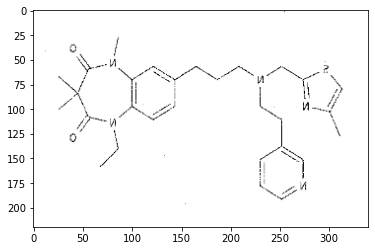

['<sos>', 'C', '29', 'H', '37', 'N', '5', 'O', '2', 'S', '/c', '1', '-', '6', '-', '34', '-', '24', '-', '12', '-', '11', '-', '22', '(', '17', '-', '25', '(', '24', ')', '32', '(', '5', ')', '27', '(', '35', ')', '29', '(', '3', ',', '4', ')', '28', '(', '34', ')', '36', ')', '10', '-', '8', '-', '15', '-', '33', '(', '19', '-', '26', '-', '31', '-', '21', '(', '2', ')', '20', '-', '37', '-', '26', ')', '16', '-', '13', '-', '23', '-', '9', '-', '7', '-', '14', '-', '30', '-', '18', '-', '23', '/h', '7', ',', '9', ',', '11', '-', '12']
['C', '29', 'H', '37', 'N', '5', 'O', '2', 'S', '/c', '1', '-', '6', '-', '34', '-', '24', '-', '12', '-', '11', '-', '22', '(', '17', '-', '25', '(', '24', ')', '32', '(', '5', ')', '27', '(', '35', ')', '29', '(', '3', ',', '4', ')', '28', '(', '34', ')', '36', ')', '10', '-', '8', '-', '15', '-', '33', '(', '19', '-', '26', '-', '31', '-', '21', '(', '2', ')', '20', '-', '37', '-', '26', ')', '16', '-', '13', '-', '23', '-', '9', '-', '7', '-', '14',

In [8]:
idx = np.random.randint(0, len(list_imgs_train)-16)

dtrain = build_dataset(list_paths[idx:idx+16], list_labels[idx:idx+16],
                       list_transforms=getTrainTransformations(), bsize=8, 
                       shuffle=True)

for batch in dtrain:
    break

data, target = batch

imgs, target_input, look_ahead_mask, pad_mask = data
print(imgs.shape, target_input.shape, look_ahead_mask.shape, pad_mask.shape, target.shape) 

plt.imshow(imgs[0]/255., cmap='gray')
plt.show()

print([tokenizer.itos[s] for s in target_input[0].numpy()[:100]])
print([tokenizer.itos[s] for s in target[0].numpy()[:100]])

In [9]:
# for epoch in range(5):
#     print(f'Epoch: {epoch}')
#     for batch in dtrain:
#         data, target = batch
#         imgs, target_input, look_ahead_mask, pad_mask = data
#         print(imgs.shape)
#         plt.imshow(imgs[0]/255., cmap='gray')
#         plt.show()

In [10]:
# v0 - max -> 26 it/s, mean -> 22 it/s
# v1 - max -> 80 it/s, mean -> 74 it/s
# dtrain = build_dataset(list_paths[:10_000], list_labels[:10_000], list_transforms=getTrainTransformations(), bsize=8)
# for i, batch in tqdm(enumerate(dtrain)):
#     if i==10_000:
#         break

In [7]:
###################################################

class EncoderImgs(models.Model):
    def __init__(self, model_base_path, trf_dim):
        super(EncoderImgs, self).__init__()
        self.trf_dim = trf_dim
        self.backbone_model = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                                                                include_top=False, weights=None)
        self.backbone_model.trainable = True
        self.base_model = tf.keras.Model(self.backbone_model.input, 
                                         self.backbone_model.layers[-1].output)
        self.drop1 = layers.Dropout(0.2)
        self.cnn_final = layers.Conv2D(SEQ_LEN_INCHI, 1, padding='same', activation='relu')
        self.reshape = layers.Reshape((5*9, SEQ_LEN_INCHI), input_shape=(5, 9, SEQ_LEN_INCHI))#7*11
        self.linear_drop = layers.Dropout(0.2)
        self.linear_proj = models.Sequential([
            layers.Dense(trf_dim, activation='linear'),
            layers.LayerNormalization(epsilon=1e-6)
        ])

        
    def call(self, img_input, training):
        x = img_input
        x = tf.keras.applications.inception_v3.preprocess_input(x)
        x = self.base_model(x, training=training)
        x = self.drop1(x, training=training)
        x = self.cnn_final(x)
        # print(x.shape)
        ##
        # x = tf.reshape(x, [tf.shape(x)[0], tf.shape(x)[1]*tf.shape(x)[2], tf.shape(x)[3]])
        x = self.reshape(x)
        # print(x.shape)
        x = tf.transpose(x, perm=[0, 2, 1])
        x = self.linear_drop(x, training)
        x = self.linear_proj(x)
        ##
        
        return x
    
    
class EncoderTransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, attention_axes=None, rate=0.1):
        super(EncoderTransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, attention_axes=attention_axes)
        self.ffn = models.Sequential(
            [layers.Dense(ff_dim, activation="relu"), 
             layers.Dense(embed_dim)]
        )
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, query, key, training, attention_mask=None):
        attn_output = self.att(query, key, attention_mask=attention_mask)
        attn_output = self.dropout1(attn_output, training=training)
        
        out1 = self.layernorm1(query + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        return self.layernorm2(out1 + ffn_output)    
    

class DecoderTransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, attention_axes=None, rate=0.1):
        super(DecoderTransformerBlock, self).__init__()
        self.att_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, attention_axes=attention_axes)
        self.att_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, attention_axes=attention_axes)
        self.ffn = models.Sequential(
            [layers.Dense(ff_dim, activation="relu"), 
             layers.Dense(embed_dim)], name='ffn_dec'
        )
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)

    def call(self, query, key, enc_output, training=True, pad_mask=None, look_ahead_mask=None):
        att1 = self.att_1(query, key, attention_mask=look_ahead_mask)
        att1 = self.dropout1(att1, training=training)
        out1 = self.layernorm1(query + att1)
        
        att2 = self.att_2(out1, enc_output, attention_mask=pad_mask)
        att2 = self.dropout2(att2, training=training)
        out2 = self.layernorm2(out1 + att2)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        
        return self.layernorm3(out2 + ffn_output)


class Encoder(layers.Layer):
    def __init__(self, trf_dim, num_heads, ff_dim, num_layers):
        super(Encoder, self).__init__()
        self.trf_dim = trf_dim
        self.num_layers = num_layers
        self.embedding = layers.Embedding(EMB_DIM, trf_dim)
        self.dropout = layers.Dropout(0.1)
        self.list_transformer_blocks = [EncoderTransformerBlock(trf_dim, num_heads, ff_dim, rate=0.1)
                                           for _ in range(num_layers)]
        
    def call(self, enc_img_input, training=True):        
        x = self.dropout(enc_img_input, training=training)
        for i in range(self.num_layers):
            x = self.list_transformer_blocks[i](x, x, training=training, attention_mask=None)
        return x
    
    
class Decoder(layers.Layer):
    def __init__(self, trf_dim, num_heads, ff_dim, num_layers):
        super(Decoder, self).__init__()
        self.trf_dim = trf_dim
        self.num_layers = num_layers
        self.embedding = layers.Embedding(EMB_DIM, trf_dim)
        self.dropout = layers.Dropout(0.1)
        self.pos_encoding = positionalEncoding(SEQ_LEN_INCHI, trf_dim)
        self.list_transformer_blocks = [DecoderTransformerBlock(trf_dim, num_heads, ff_dim, rate=0.1)
                                           for _ in range(num_layers)]
        
    def call(self, inputs, training=True):
        enc_out, dec_input, look_ahead_mask, pad_mask = inputs
        seq_len = tf.shape(dec_input)[1]
        
        x = self.embedding(dec_input)
        x *= tf.math.sqrt(tf.cast(self.trf_dim, tf.float16))#tf.float16))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.list_transformer_blocks[i](x, x, enc_out, training=training, 
                                                look_ahead_mask=look_ahead_mask, pad_mask=None)
        return x

    
class TransformerModel(models.Model):
    def __init__(self, model_base_path, trf_dim, num_heads, ff_dim, num_enc_layers, num_dec_layers):
        super(TransformerModel, self).__init__()
        self.trf_dim = trf_dim
        self.img_encoder = EncoderImgs(model_base_path, trf_dim)
        self.encoder = Encoder(trf_dim=trf_dim, num_heads=num_heads, ff_dim=trf_dim*4, num_layers=num_enc_layers)
        self.decoder = Decoder(trf_dim=trf_dim, num_heads=num_heads, ff_dim=trf_dim*4, num_layers=num_dec_layers)
        ###
        self.final_layer = layers.Dense(EMB_DIM, activation='linear')
    
    def call(self, inputs, training=True):
        ###
        imgs, in_target, look_ahead_mask, pad_mask = inputs
        seq_len = tf.shape(in_target)[1]
        ### 
        ###
        imgs_features = self.img_encoder(imgs, training)
        encoder_out = self.encoder(imgs_features, training)
        x = self.decoder((encoder_out, in_target, look_ahead_mask, pad_mask), training=training)
        logits = self.final_layer(x)
        
        return logits

    
def getTransformerModel(model_img_base_path, trf_dim, num_heads, ff_dim, num_enc_layers, num_dec_layers):
    return TransformerModel(model_img_base_path, trf_dim, num_heads, ff_dim, num_enc_layers, num_dec_layers)


loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
def loss_function(real, pred):
    mask = tf.math.not_equal(real, 0)
    loss_ = loss_object(tf.cast(real, tf.float32), tf.cast(pred, tf.float32))

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(tf.cast(real, tf.float32), tf.cast(tf.argmax(pred, axis=2), tf.float32))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float16)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.cast(tf.math.minimum(arg1, arg2), tf.float16)#, tf.float32)
    
train_step_signature = [
    tf.TensorSpec(shape=(None, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32),
    tf.TensorSpec(shape=(None, SEQ_LEN_INCHI), dtype=tf.float32),
    tf.TensorSpec(shape=(None, SEQ_LEN_INCHI, SEQ_LEN_INCHI), dtype=tf.float32),
    tf.TensorSpec(shape=(None, 1, 1, SEQ_LEN_INCHI), dtype=tf.bool),
    tf.TensorSpec(shape=(None, SEQ_LEN_INCHI), dtype=tf.float32)
]   
@tf.function(input_signature=train_step_signature)
def train_step(imgs, target_input, look_ahead_mask, pad_mask, tar_real):
    with tf.GradientTape() as tape:
        inputs = (imgs, target_input, look_ahead_mask, pad_mask)
        predictions = transformer(inputs, training=True)
        loss = loss_function(tar_real, predictions)
        scaled_loss = optimizer.get_scaled_loss(loss)
        
    scaled_gradients = tape.gradient(scaled_loss, transformer.trainable_variables)
    gradients = optimizer.get_unscaled_gradients(scaled_gradients)
#     gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))  
    
    
test_step_signature = [
    tf.TensorSpec(shape=(None, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32),
    tf.TensorSpec(shape=(None, SEQ_LEN_INCHI), dtype=tf.float32),
    tf.TensorSpec(shape=(None, SEQ_LEN_INCHI, SEQ_LEN_INCHI), dtype=tf.float32),
    tf.TensorSpec(shape=(None, 1, 1, SEQ_LEN_INCHI), dtype=tf.bool),
    tf.TensorSpec(shape=(None, SEQ_LEN_INCHI), dtype=tf.float32)
]   
@tf.function(input_signature=test_step_signature)
def test_step(imgs, target_input, look_ahead_mask, pad_mask, tar_real):
    inputs = (imgs, target_input, look_ahead_mask, pad_mask)
    predictions = transformer(inputs, training=False)
    loss = loss_function(tar_real, predictions)
    val_loss(loss)
    val_accuracy(accuracy_function(tar_real, predictions)) 
    pred_tokens = tf.argmax(predictions, -1)
    val_metric(get_levenshtein_distance(tf.cast(pred_tokens, tf.float64), tf.cast(tar_real, tf.float64)))
    
def dense_to_sparse(dense):
    indices = tf.where(tf.ones_like(dense))
    values = tf.reshape(dense, (SEQ_LEN_INCHI*batch_size,))
    sparse = tf.SparseTensor(indices, values, (batch_size, SEQ_LEN_INCHI))
    return sparse

def get_levenshtein_distance(preds, lbls):
    bs = preds.shape[0]
    preds = tf.where(tf.not_equal(lbls, tokenizer.stoi['<eos>']) & tf.not_equal(lbls, tokenizer.stoi['<pad>']), preds, 0)
    lbls = tf.where(tf.not_equal(lbls, tokenizer.stoi['<eos>']), lbls, 0)

    preds_sparse = dense_to_sparse(preds)
    lbls_sparse = dense_to_sparse(lbls)

    batch_distance = tf.edit_distance(preds_sparse, lbls_sparse, normalize=False)
    mean_distance = tf.math.reduce_mean(batch_distance)
    
    return mean_distance

###################################################

In [12]:
###################################################
# Training

tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(True)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

num_epochs = 10
trf_dim = 256
num_enc_layers = 2
num_dec_layers = 4
num_heads = 4
batch_size = 20
val_size = 0.05
batch_num_printer_train, batch_num_printer_val = 250, 100
model_name = 'full_inchi_chform_opt_v1.4'
checkpoint_path = f'../03_Models/00_Checkpoints/{model_name}/'
restore_last_chekpoint = (True, '../03_Models/00_Checkpoints/final_model_v1.3/ckpt-7')

rand_idxs = np.arange(300_000)
np.random.shuffle(rand_idxs)
list_paths_sample, list_labels_sample = list(np.asarray(list_paths)[rand_idxs]), list(np.asarray(list_labels)[rand_idxs])
thresh = int(len(list_paths_sample)*(1-val_size))

train_data_generator = build_dataset(list_paths_sample[:thresh], list_labels_sample[:thresh], bsize=batch_size,
                                    list_transforms=getTrainTransformations())
val_data_generator = build_dataset(list_paths_sample[thresh:], list_labels_sample[thresh:], bsize=batch_size,
                                  list_transforms=None)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')
val_metric = tf.keras.metrics.Mean(name='val_lvsd')

learning_rate = CustomSchedule(trf_dim)
optimizer = optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
optimizer = mixed_precision.LossScaleOptimizer(optimizer)

transformer = TransformerModel(None, trf_dim, num_heads, trf_dim*4, num_enc_layers, num_dec_layers)
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if restore_last_chekpoint[0]:
    ckpt.restore(restore_last_chekpoint[1])
    print('Latest checkpoint restored!!')

for epoch in range(num_epochs):
    start = time.time()
    print('===='*20)
    print(f'Epoch {epoch + 1}')
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()
    val_metric.reset_states()
    for batch_num, batch_data in enumerate(train_data_generator):
        data, target = batch_data
        imgs, target_input, look_ahead_mask, pad_mask = data
        target = tf.cast(target, tf.float32)
        target_input = tf.cast(target_input, tf.float32)
        train_step(imgs, target_input, look_ahead_mask, pad_mask, target)

        if batch_num % batch_num_printer_train == 0:
            printer = f'Train Epoch {epoch + 1} Time {time.time() - start:.2f} Batch {batch_num}/{len(train_data_generator)} '
            printer += f'Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}'
            print(printer)
            
    for val_batch_num, val_batch_data in enumerate(val_data_generator):
        data, target = val_batch_data
        imgs, target_input, look_ahead_mask, pad_mask = data
        target = tf.cast(target, tf.float32)
        target_input = tf.cast(target_input, tf.float32)
        test_step(imgs, target_input, look_ahead_mask, pad_mask, target)
        
        if val_batch_num % batch_num_printer_val == 0:
            printer = f'Val Epoch {epoch + 1} Time {time.time() - start:.2f} Batch {val_batch_num}/{len(val_data_generator)} '
            printer += f'Loss {val_loss.result():.4f} Accuracy {val_accuracy.result():.4f} Val LVSD {val_metric.result():.4f}'
            print(printer)
            
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {checkpoint_path}')
    
    print(f'\nTime taken for epoch {epoch+1}/{num_epochs}: {time.time() - start:.2f} secs')
    printer = f'Epoch {epoch + 1} - Train Loss {train_loss.result():.4f} - Train Accuracy {train_accuracy.result():.4f} '
    printer += f'- Val Loss {val_loss.result():.4f} - Val Accuracy {val_accuracy.result():.4f} - Val LVSD {val_metric.result():.4f}'
    print(printer)
    
    wandb.log({'epochs': epoch,
                'train_loss': train_loss.result(),
                'train_acc': train_accuracy.result(), 
                'val_loss': val_loss.result(),
                'val_acc': val_accuracy.result(),
                'val_lvsd' : val_metric.result()})


###################################################

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5
Latest checkpoint restored!!
Epoch 1
Train Epoch 1 Time 61.67 Batch 0/14250 Loss 1.5904 Accuracy 0.7460
Train Epoch 1 Time 122.24 Batch 250/14250 Loss 0.1005 Accuracy 0.9679
Train Epoch 1 Time 182.56 Batch 500/14250 Loss 0.0877 Accuracy 0.9707
Train Epoch 1 Time 241.54 Batch 750/14250 Loss 0.0831 Accuracy 0.9718
Train Epoch 1 Time 300.03 Batch 1000/14250 Loss 0.0808 Accuracy 0.9723
Train Epoch 1 Time 358.69 Batch 1250/14250 Loss 0.0787 Accuracy 0.9728
Train Epoch 1 Time 417.22 Batch 1500/14250 Loss 0.0770 Accuracy 0.9733
Train Epoch 1 Time 476.21 Batch 1750/14250 Loss 0.0761 Accuracy 0.9736
Train Epoch 1 Time 534.98 Batch 2000/14250 Loss 0.0752 Accuracy 0.9738
Train Epoch 1 Time 593.31 Batch 2250/14250 Loss 0.0745 Accuracy 0.9740
Train Epoch 1 Time 

KeyboardInterrupt: 

In [13]:
# Time taken for epoch 2/10: 2052.97 secs
# Epoch 2 - Train Loss 0.6351 - Train Accuracy 0.7764 - Val Loss 0.6790 - Val Accuracy 0.7737 - Val LVSD 20.5271

# Time taken for epoch 2/10: 2078.89 secs
# Epoch 2 - Train Loss 0.6421 - Train Accuracy 0.7740 - Val Loss 0.5503 - Val Accuracy 0.8042 - Val LVSD 17.8266

# Time taken for epoch 2/10: 2788.95 secs
# Epoch 2 - Train Loss 0.5599 - Train Accuracy 0.8037 - Val Loss 0.4647 - Val Accuracy 0.8364 - Val LVSD 14.9557

In [14]:
#(50k) # Time taken for epoch 10/10: 838.28 secs
# Epoch 10 - Train Loss 0.7291 - Train Accuracy 0.7444 - Val Loss 0.7268 - Val Accuracy 0.7479 - Val LVSD 22.8804
# (250k) # Time taken for epoch 6/10: 4300.91 secs
# Epoch 6 - Train Loss 0.6127 - Train Accuracy 0.7827 - Val Loss 0.5705 - Val Accuracy 0.7979 - Val LVSD 18.3881

In [8]:
###################################################
# Inference

def getInfValidTransformations():
    return albumentations.Compose([
        albumentations.Resize(IMG_SIZE[0], IMG_SIZE[1], always_apply=True)])

def getInfFixTestTransformations():
    return albumentations.Compose([
        albumentations.Transpose(always_apply=True),
        albumentations.VerticalFlip(always_apply=True),
        albumentations.Resize(IMG_SIZE[0], IMG_SIZE[1], always_apply=True)])


def createPaddingMask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.bool)
    # add extra dimensions to add the padding to the attention logits.
    # (batch_size, 1, 1, sequence length)
    mask = mask[:, tf.newaxis, :]
    return mask
    
def causal_attention_mask(seq_len):
    i = tf.range(seq_len)[:, tf.newaxis]
    j = tf.range(seq_len)
    mask = tf.cast(i >= j, dtype=tf.int32)
    mask = tf.reshape(mask, (-1, seq_len, seq_len))
    mult = tf.concat(
        [tf.expand_dims(1, -1), tf.constant([1, 1], dtype=tf.int32)],
        axis=0,
    )
    return tf.tile(mask, mult)


def createMasks(tar_inp):
    look_ahead_mask = causal_attention_mask(tf.shape(tar_inp)[1])   
    return look_ahead_mask

def readImageTF(img_path, ext='jpg'):
    file_bytes = tf.io.read_file(img_path)
    if ext == 'png':
        img = tf.image.decode_png(file_bytes, channels=3)
    elif ext in ['jpg', 'jpeg']:
        img = tf.image.decode_jpeg(file_bytes, channels=3)
    else:
        raise ValueError("Image extension not supported")

    img = tf.cast(img, tf.float32)
    h_src = tf.shape(img)[0]
    w_src = tf.shape(img)[1] 
            
    if h_src>w_src: # pad width
        img = tf.image.rot90(img)
        
    img = tf.image.resize(img, (IMG_SIZE[0], IMG_SIZE[1]))
    return img.numpy()
    
    
inference_step_signature = [
    tf.TensorSpec(shape=(None, SEQ_LEN_INCHI, 256), dtype=tf.float16),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None, None), dtype=tf.int32)
]   
@tf.function(input_signature=inference_step_signature)
def predictToken(imgs_features, output, look_ahead_mask):
    dec_out = model.decoder((imgs_features, output, look_ahead_mask, None), training=False)
    predictions = model.final_layer(dec_out)
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    return predicted_id    
    
    
def evaluateListImg(list_img_path, model, max_length=10, trf_dim=256):
    batch_size = tf.constant(len(list_img_path))
    imgs = tf.concat([tf.expand_dims(readImageTF(img_path), 0) for img_path in list_img_path], axis=0)

    output = tf.convert_to_tensor([tokenizer.stoi['<sos>'] for _ in range(batch_size)])
    output = tf.expand_dims(output, -1)
    
    imgs_features = model.img_encoder(imgs, training=False)
    imgs_features = model.encoder(imgs_features, training=False)
    # Placeholder for not padding the image encoder as  we want all the seq_len from encoder
    for _ in tf.range(max_length):
        look_ahead_mask = createMasks(output)
        # predictions.shape == (batch_size, seq_len, vocab_size)
        
        # inputs = (imgs, output, look_ahead_mask, pos_encoding)
        # predictions = model(inputs, training=False)
#         inputs = (imgs_features, output, look_ahead_mask, None)
#         dec_out = model.decoder(inputs, training=False)
#         predictions = model.final_layer(dec_out)
        
#         # select the last word from the seq_len dimension
#         predictions = predictions[:, -1:, :]
#         predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        predicted_id = predictToken(imgs_features, output, look_ahead_mask)
        output = tf.concat([output, predicted_id], axis=-1)

#         # return the result if the predicted_id is equal to the end token
        if tf.reduce_sum(tf.cast(tf.reduce_any(tf.equal(output, tokenizer.stoi['<eos>'])\
                                               , -1), tf.int32))== batch_size:
            break
                
    return output, imgs

###################################################

In [9]:
###################################################
# Load pub sub and predict only not found by rdkit

df_sub = pd.read_csv('../99_FinalSubmission/0_submission_2_53_norm.csv')
df_sub['in_found_rdkit'] = df_sub['InChI'].apply(lambda x : 0 if x is np.nan else 1)

dict_test_not_found = {elem['image_id'] : elem['in_found_rdkit'] 
                       for elem in df_sub[['image_id', 'in_found_rdkit']].to_dict('records')}

###################################################

In [12]:
###################################################

with open(f'./list_nf.pkl', 'rb') as f:
    list_imgs_test_nf = pkl.load(f)

# Inference

tf.keras.backend.clear_session()
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

batch_size = 64
trf_dim = 256
num_enc_layers = 2
num_dec_layers = 4
num_heads = 4
path_load_weights = PATH_MODELS + '00_Checkpoints/final_model_v1_4/ckpt-12'
model = TransformerModel(None, trf_dim, num_heads, trf_dim*4, num_enc_layers, num_dec_layers)
learning_rate = CustomSchedule(trf_dim)
optimizer = optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
optimizer = mixed_precision.LossScaleOptimizer(optimizer)
ckpt = tf.train.Checkpoint(transformer=model, optimizer=optimizer)
ckpt.restore(path_load_weights)
print('Checkpoint restored!!')

# Only not found
# list_imgs_test_nf = [img_id for img_id in dict_test_not_found if dict_test_not_found[img_id]==0]
print(f'Imgs not found: {len(list_imgs_test_nf)}')
# list_imgs_test_nf = list_imgs_test.copy()
list_chunks_imgs_test = [list_imgs_test_nf[i:(i+batch_size)] for i in range(0, len(list_imgs_test_nf), batch_size)]   

list_image_id, list_pred_inchis = [], []
for chunk_images in tqdm(list_chunks_imgs_test, position=0):
    list_paths = [dict_imgs_test_paths[img_id] for img_id in chunk_images]
    prediction, imgs_ = evaluateListImg(list_paths, model, max_length=SEQ_LEN_INCHI, trf_dim=trf_dim)
    pred_seq = prediction.numpy()[:, 1:]
    pred_inchi = ['InChI=1S/' + tokenizer.sequence_to_text(seq).split('<eos>')[0] for seq in pred_seq]
    assert len(pred_inchi)==len(list_paths)
    list_image_id.extend(chunk_images)
    list_pred_inchis.extend(pred_inchi)
    
###################################################

Checkpoint restored!!
Imgs not found: 73863


KeyboardInterrupt: 

In [10]:
# file_bytes = tf.io.read_file(dict_imgs_test_paths[list_image_id[1337]])
# img = tf.image.decode_png(file_bytes, channels=3)
# img = tf.cast(img, tf.float32)
# h_src = tf.shape(img)[0]
# w_src = tf.shape(img)[1] 

# if h_src>w_src: # pad width
#     img = tf.image.rot90(img)

# img = tf.image.resize(img, (IMG_SIZE[0], IMG_SIZE[1]))
    
# plt.imshow(img/255.)
# plt.show()

In [51]:
# plt.imshow(imgs_[1337]/255.)
# plt.show()

In [15]:
###################################################
# Prepare submission

df_predictions = pd.DataFrame({
    'image_id' : list_image_id,
    'InChI' : list_pred_inchis
})

df_merged = pd.merge(df_sub, df_predictions, how='left', suffixes=('_1', '_2'), on='image_id')
                                 
###################################################

In [16]:
###################################################
# Build submission

list_imgs_id = []
list_values_inchi = []
list_elems = df_merged.to_dict('records')
for elem in tqdm(list_elems):
    if elem['in_found_rdkit']==0 and elem['InChI_2'] is not np.nan:
        if len(elem['InChI_2'])>=20:
            inchi_ = elem['InChI_2']
        else:
            inchi_ = elem['InChI_1']
    else:
        inchi_ = elem['InChI_1'] 
    list_values_inchi.append(inchi_)  
    list_imgs_id.append(elem['image_id'])

df_submission = pd.DataFrame({
    'image_id' : list_imgs_id,
    'InChI' : list_values_inchi,
})

df_submission.to_csv('../04_Submissions/Iter3/submission_fix_not_found_3_15.csv', index=False)
df_submission.head()

###################################################

,image_id,InChI
0,4c0618918583,"InChI=1S/C22H20Br3N11O2/c23-8-2-10(24)17(33-16(8)34)22(38)29-5-7-1-11(32-18(35)12-4-14(26)15(25)31-12)9(7)3-28-21(27)35-20-13(6)34-21(20)30-21/h2,4,7,9,11,28H,1,3,5,26H2,(H2,27,31)(H,29,35)(H,33,34)(H3,30,32,38)"
1,25e547a2765a,"InChI=1S/C18H16O3/c1-3-10-9-14-15(17(20)11(10)4-2)18(21)13-8-6-5-7-12(13)16(14)19/h5-9,20H,3-4H2,1-2H3"
2,4c06208f97ab,"InChI=1S/C17H13ClFN5O2S/c18-12-4-13(19)11(16(26)23-9-1-2-9)3-10(12)8-5-22-24(7-8)14-6-21-17(27-14)15(20)25/h3-7,9H,1-2H2,(H2,20,25)(H,23,26)"
3,25e54ec918f0,"InChI=1S/C26H26N4O2/c1-3-30-18(2)27-23-16-21(14-15-24(23)30)26(32)29-28-25(31)17-22(19-10-6-4-7-11-19)20-12-8-5-9-13-20/h4-16,22H,3,17H2,1-2H3,(H,28,31)(H,29,32)"
4,4c06283ae4de,"InChI=1S/C14H16N2O3/c1-19-7-6-16(12-3-4-12)13-5-2-10(14(17)18)8-11(13)9-15/h2,5,8,12H,3-4,6-7H2,1H3,(H,17,18)"
